#### Build a Movie Recommender System with Collaborative Filtering Learning Algorithm
In this project, we will implement the collaborative filtering
learning algorithm and apply it to a dataset of movie ratings. This dataset
consists of ratings on a scale of 1 to 5. The dataset has 943 users, and
1682 movies. Image Below just for **illustration** purpose only.

<img src="./images/Recommender_system.png" alt="Image for illustration purpose only" width="400" />


In [228]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
import warnings; warnings.simplefilter('ignore')

In [229]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i


data = loadmat('./data/movie_recommender_system.mat')
Y = data['Y']
R = data['R']
print('Average rating for movie 1 (Toy Story): %f / 5\n\n' % np.mean(Y[0, np.where(R[0, :]==1)]))

Average rating for movie 1 (Toy Story): 3.878319 / 5




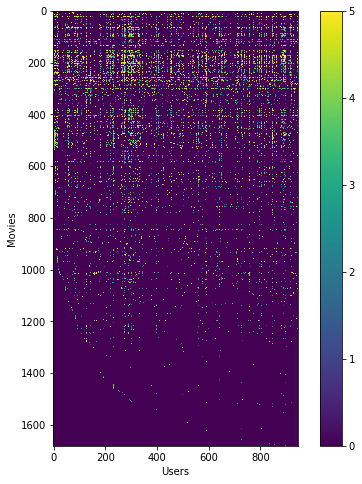

In [243]:
# We can "visualize" the ratings matrix by plotting it with imshow. Dark Blue means no-rating.
plt.figure(figsize=(8,8))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

In [231]:
data1 = loadmat('./data/movieParams.mat')
data1.keys()
# X is matrix storing (Num_movies x Num_movie_features)
X = data1['X']
Theta = data1['Theta']
num_users = data1['num_users'][0,0]
num_movies = data1['num_movies'][0,0]
num_features = data1['num_features'][0,0]

In [232]:
#  Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3;
X = X[:num_movies, :num_features];
Theta = Theta[:num_users, :num_features];
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [233]:
# Evaluate cost function
def cofiCostFunc(params, Y, R, num_users, num_movies,num_features, lamda):
#    print(params.shape)
    X =params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    J = 0;
    X_grad = np.zeros(X.shape);
    Theta_grad = np.zeros(Theta.shape);
    
    J_matrix = np.zeros(Y.shape);
    J_matrix = 1/2* (X.dot(Theta.T)-Y)**2

    J = J + np.sum(R*J_matrix);

    X_grad     = X_grad     + (R*(X.dot(Theta.T)-Y)).dot(Theta)

    Theta_grad = Theta_grad + (R*(X.dot(Theta.T)-Y)).T.dot(X)

    J = J + (lamda/2)* ( np.sum(Theta**2) +  np.sum(X**2) )

    X_grad = X_grad + lamda*X

    Theta_grad = Theta_grad + lamda*Theta

    # =============================================================

    grad = np.append(X_grad.reshape(-1,1), Theta_grad.reshape(-1,1), axis=0)
    return J, grad

In [286]:
def computeNumericalGradient(J,theta):
    e = 1e-3
    numgrad = np.zeros(theta.shape)
    perturb = e * np.eye(theta.size)
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:,i].reshape(-1,1))
        loss2, _ = J(theta + perturb[:,i].reshape(-1,1))
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad    

def checkCostFunction(lamda=0):
    ## Create small problem
    X_t = np.random.rand(4, 3);
    Theta_t = np.random.rand(5, 3);

    # Zap out most entries
    Y = X_t .dot(Theta_t.T);
    Y[np.random.rand(Y.shape[0],Y.shape[1]) > 0.5] = 0;
    R = np.zeros(Y.shape);
    R[Y != 0] = 1;

    ## Run Gradient Checking
    X = np.random.rand(X_t.shape[0], X_t.shape[1]);
    Theta = np.random.rand(Theta_t.shape[0], Theta_t.shape[1]);
    num_users = Y.shape[1];
    num_movies = Y.shape[0];
    num_features = Theta_t.shape[1];
    

    initial_parameters = np.append(X.reshape(-1,1), Theta.reshape(-1,1), axis=0)
    numgrad = computeNumericalGradient(lambda x: cofiCostFunc(x, Y, R, num_users, num_movies, num_features, lamda), \
                                        initial_parameters)
    
    cost, grad = cofiCostFunc(initial_parameters, Y, R, num_users, num_movies,num_features, lamda)

#    print(np.append(numgrad, grad, axis=1));
#   print('The above two columns you get should be very similar.\n \
#             Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n');

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);
    print('If your cost function implementation is correct, then \n \
             the relative difference will be small (less than 1e-9). Relative Difference: %g\n' % diff);

In [287]:
## Check Gradient
checkCostFunction(lamda=1.5)

If your cost function implementation is correct, then 
              the relative difference will be small (less than 1e-9). Relative Difference: 1.69767e-13



In [271]:
def loadMovieList():
    ## Read the fixed movieulary list
    with open('./data/movie_ids.txt',encoding = "ISO-8859-1") as f:
        # Store all movies in cell array movie{}
        s = f.readlines()
        li = [' '.join(j for j in i.split()[1:]).rstrip() for i in s]
    return li
li = loadMovieList()
my_ratings = np.zeros((1682,1))
### User New ratings
my_ratings[0] = 4;
my_ratings[97] = 2;
my_ratings[6]= 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354]= 5;

In [272]:
def normalizeRatings(Y,R):
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))    
    Ynorm = Y-Ymean
    return Ynorm, Ymean

data2 = loadmat('./data/movies.mat')
Y = data2['Y']
R = data2['R']
Y = np.append(Y, my_ratings, axis=1)
R = np.append(R, my_ratings!=0,axis=1)
# Normalize Rattings
Ynorm, Ymean = normalizeRatings(Y,R)

num_users = Y.shape[1];
num_movies = Y.shape[0];
num_features = 10;

# Initial Parameters 
X = np.random.rand(num_movies,num_features)
Theta = np.random.rand(num_users,num_features)

initial_parameters = np.append(X.reshape(-1,1), Theta.reshape(-1,1), axis=0)
lamda = 10

#### Parameter (Movie Features X and Feature coefficient Theta) optimisation 

In [274]:
xopt = minimize(cofiCostFunc, x0=initial_parameters, args = (Ynorm, R, num_users, num_movies,num_features, lamda), jac= True, method='TNC', options={'disp': True})

In [275]:
X = xopt.x[:num_movies*num_features].reshape(num_movies, num_features)
Theta = xopt.x[num_movies*num_features:].reshape(num_users, num_features)

End of Recommender system learning.

#### Recommendation for the New user

In [288]:
p = X.dot(Theta.T)
my_predictions = p[:,-1] + np.squeeze(Ymean)
li_pred = [(i,my_predictions[i]) for i in range(len(my_predictions))]
li_pred = sorted(li_pred, key=lambda x:x[1], reverse=True)
print('Top recommendations for you:\n')
for i in range(20):
    j = li_pred[i][0]
    print('Predicting rating %.2f for movie: %s' % (li_pred[i][1], loadMovieList()[j]))

Top recommendations for you:

Predicting rating 5.00 for movie: Saint of Fort Washington, The (1993)
Predicting rating 5.00 for movie: Star Kid (1997)
Predicting rating 5.00 for movie: Prefontaine (1997)
Predicting rating 5.00 for movie: Santa with Muscles (1996)
Predicting rating 5.00 for movie: Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.00 for movie: Aiqing wansui (1994)
Predicting rating 5.00 for movie: Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.00 for movie: Someone Else's America (1995)
Predicting rating 5.00 for movie: They Made Me a Criminal (1939)
Predicting rating 5.00 for movie: Great Day in Harlem, A (1994)
Predicting rating 4.64 for movie: Pather Panchali (1955)
Predicting rating 4.63 for movie: Star Wars (1977)
Predicting rating 4.55 for movie: Shawshank Redemption, The (1994)
Predicting rating 4.52 for movie: Maya Lin: A Strong Clear Vision (1994)
Predicting rating 4.50 for movie: Anna (1996)
Predicting rating 4.50 for movie: 

In [279]:
print('Original ratings provided:\n');
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for movie: %s'% (my_ratings[i], loadMovieList()[i]))


Original ratings provided:

Rated 4 for movie: Toy Story (1995)
Rated 3 for movie: Twelve Monkeys (1995)
Rated 5 for movie: Usual Suspects, The (1995)
Rated 4 for movie: Outbreak (1995)
Rated 5 for movie: Shawshank Redemption, The (1994)
Rated 3 for movie: While You Were Sleeping (1995)
Rated 5 for movie: Forrest Gump (1994)
Rated 2 for movie: Silence of the Lambs, The (1991)
Rated 4 for movie: Alien (1979)
Rated 5 for movie: Die Hard 2 (1990)
Rated 5 for movie: Sphere (1998)
